In [1]:
# Deep dream is used to modify the current image into psychedalic images using covnets

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
base_image_path = r"E:\Jupyter Files\Deep learning practice\artifacts\coast.jpg"

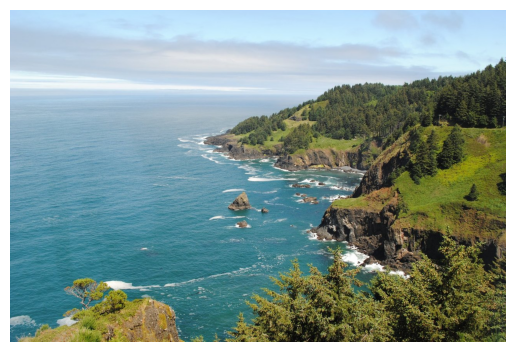

In [4]:
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [5]:
# Any pretrained covnets can be used to modify the current image into psychedalic images like Inception or VGG16 etc.
# Each model creates different visualizations, and Inception model is known to create nice looking deep dreams

In [6]:
from keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet",include_top=False) # Loading the inception model which is trained on imagenet dataset and the last dense classification layer not taken

In [7]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [8]:
# mixed4, mixed5, mixed6 and mixed7 are the concatenation layers 

In [9]:
from keras.models import Model

In [10]:
layer_settings = { # We are trying maximize activation and their weights in total loss ( Change these values for new visual effects)
    "mixed4" : 1.0,
    "mixed5" : 1.5,
    "mixed6" : 2.0,
    "mixed7" : 2.5
}

outputs_dict = dict(
    [
        (layer.name,layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()] # Extracting layer name and output values for the layers we are tweaking the values

    ]
)
feature_extractor = Model(inputs=model.inputs,outputs=outputs_dict) # Model that returns the activation values for every target layer( the layer whose value we have tweaked above)

In [11]:
def compute_loss(input_image):
    features = feature_extractor(input_image) # Extract the activation values for the layers
    loss = tf.zeros(shape=()) # Loss initialized to zero
    for name in features.keys():
        coeff = layer_settings[name] # Extracting the values we mentioned or tweaked
        activation = features[name] # Activations of the layers
        loss += coeff * tf.reduce_mean(tf.square(activation[:,2:-2,2:-2,:])) # Loss calculation ( We avoid border artifacts by involving non border pixels in loss calculation)
    return loss

1. Gradient ascent is an optimization algorithm used to maximize a function. It is the counterpart of gradient descent, which is used to minimize a function. The idea behind gradient ascent is to iteratively update the parameters of a model in the direction of the gradient of the objective function with respect to those parameters. This means that in each iteration, the parameters are adjusted in a way that increases the value of the objective function.
2. The main purpose while using deep dream is to maximize certain features of the image by iteratively adjusting it to increase a predefined loss function. The gradient ascent process aims to modify the image in a way that amplifies these features. The learning rate determines the step size for each update, and the iterations control the number of steps taken during optimization. Additionally, the maximum loss threshold prevents over-optimization, which could lead to undesirable artifacts in the generated images.

In [12]:
# Gradient Ascent process

@tf.function
def gradient_ascent_step(image,learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss,image) # Gradient of deep dream loss wrt original image
    grads = tf.math.l2_normalize(grads) # Normalizing gradients( to prevent gradient vanishing or exploding , and helps in convergence)
    image += learning_rate * grads
    return loss,image

def gradient_ascent_loop(image,iterations,learning_rate,max_loss=None):
    for i in range(iterations): # Loop to repeatedly update the image in a way to increase the deep dream loss
        loss,image = gradient_ascent_step(image,learning_rate) # Loss and Image calculation
        if max_loss is not None and loss > max_loss: # Break loop if loss crosses a certain threshold(over optmization will lead to unwanted images)
            break
        print(f"...Loss value at step{i} : {loss:.2f}")
    return image

In [13]:
step = 20 # gradient ascent step size
num_octave = 3 # Number of scales at which to run the gradient ascent
octave_scale = 1.4 # Size ratio between successive scales
iterations = 30 # Number of gradient ascene steps per scale
max_loss = 15. # Max loss at which we stop the gradient ascent process

In [18]:
def preprocess_image(image_path): # Function to preprocess image for model input
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img): # Convert the image array back to an image
    img = img.reshape((img.shape[1] , img.shape[2] , 3))
    # Undoing inception model preprocessing
    img /= 2.0
    img += 0.5
    img *= 255.0
    img = np.clip(img, 0, 255).astype('uint8') # Converting the uint8 and clip to valid range [0,255]
    return img

In [19]:
# The below lines involves scaling down the original image, performing gradient ascent to enhance features at each scale, and then adding back the lost high-frequency details to the image. These steps are repeated iteratively to generate the final DeepDream image.
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3] # Original image shape --> (height,width,number of channels), so we are extracting the height and width

successive_shapes = [original_shape] # This list will store the shapes of the image at different octaves (or scales) during the DeepDream process(currently initialized with original shape)
for i in range(1, num_octave): # Loop iterating through each octave ( Octave means scaling the image to a larger size / smaller size)(here we scale it down ,so divide is used)
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape]) # Calculating the shape tuple for the smaller rescaled image
    successive_shapes.append(shape) # Appending the list with the new shape
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0]) # Resizing the image with the new shape calculated above

img = tf.identity(original_img) # Creating a copy of the original_img tensor 
for i, shape in enumerate(successive_shapes): # Loop across each calculated shape
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape) # Copied image is resized to the new calculated shape of the octave
    img = gradient_ascent_loop( # Gradient ascent step to maximise the activations of the layers
    img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) # Resizing the shrunk_original_img tensor
    same_size_original = tf.image.resize(original_img, shape) # Resizing the original image 
    lost_detail = same_size_original - upscaled_shrunk_original_img # Calculating the loss detail(which is added to the deep dream output image so that no details are lost during the process) ( similar to residual connection)
    img += lost_detail 
    shrunk_original_img = tf.image.resize(original_img, shape) 
    
keras.utils.save_img("artifacts\dream.png", deprocess_image(img.numpy())) # Using deprocess function to get the deep dream image and save it

Processing octave 0 with shape (437, 653)
...Loss value at step0 : 0.77
...Loss value at step1 : 1.09
...Loss value at step2 : 1.46
...Loss value at step3 : 1.84
...Loss value at step4 : 2.19
...Loss value at step5 : 2.52
...Loss value at step6 : 2.91
...Loss value at step7 : 3.24
...Loss value at step8 : 3.58
...Loss value at step9 : 3.89
...Loss value at step10 : 4.19
...Loss value at step11 : 4.54
...Loss value at step12 : 4.92
...Loss value at step13 : 5.19
...Loss value at step14 : 5.57
...Loss value at step15 : 5.80
...Loss value at step16 : 6.18
...Loss value at step17 : 6.46
...Loss value at step18 : 6.84
...Loss value at step19 : 7.19
...Loss value at step20 : 7.50
...Loss value at step21 : 7.83
...Loss value at step22 : 8.21
...Loss value at step23 : 8.43
...Loss value at step24 : 8.71
...Loss value at step25 : 9.17
...Loss value at step26 : 9.42
...Loss value at step27 : 9.79
...Loss value at step28 : 10.19
...Loss value at step29 : 10.65
Processing octave 1 with shape (612,

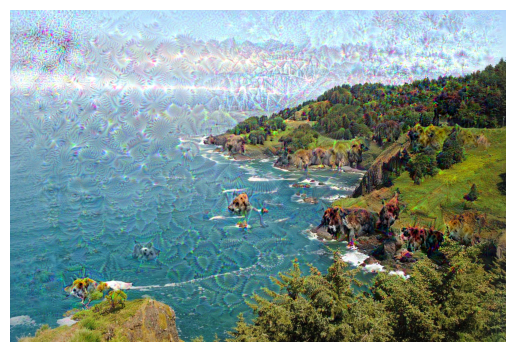

In [20]:
plt.axis("off")
plt.imshow(keras.utils.load_img("artifacts\dream.png"))